# 안경 착용 여부 분류
- AlexNet 사용

In [2]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [29]:
device = 'mps'

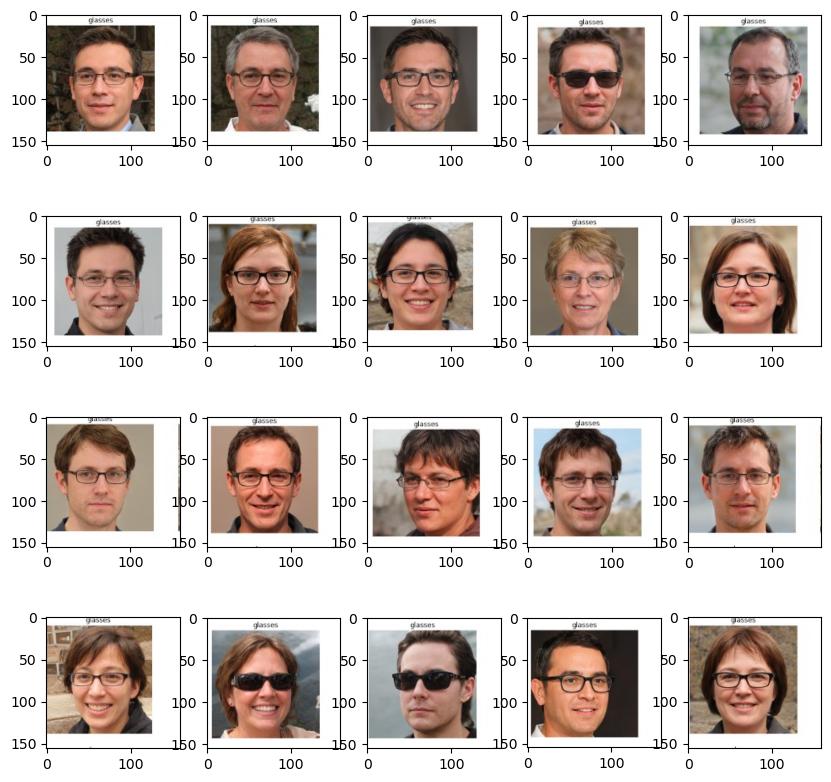

In [5]:
train_clean_img_list = os.listdir('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/train/glasses')

plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    root = os.path.join('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/train/glasses', train_clean_img_list[i])
    img = Image.open(root)
    plt.imshow(img)

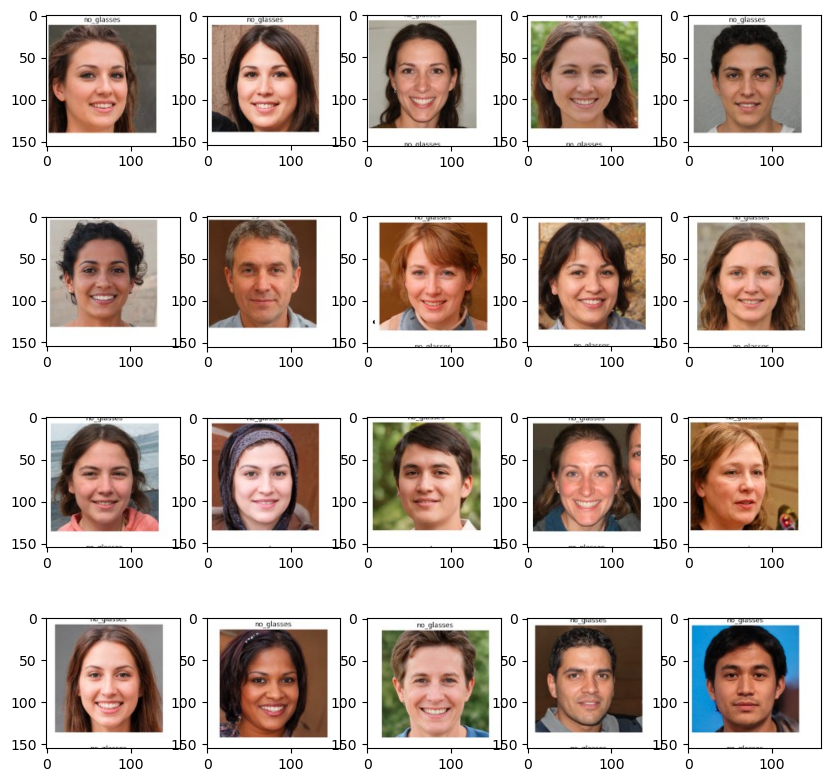

In [9]:
train_clean_img_list = os.listdir('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/train/noglasses')

plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    root = os.path.join('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/train/noglasses', train_clean_img_list[i])
    img = Image.open(root)
    plt.imshow(img)

# Dataset

## 1. CustomDataset class 생성

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dir, classes, transform):
        super().__init__()
        self.data = []
        self.transform = transform

        for i in range(len(classes)):
            root_dir = os.path.join(dir, classes[i])
            img_list = os.listdir(root_dir)
            for img in img_list:
                self.data.append((os.path.join(root_dir, img), i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx][0], self.data[idx][1]
        img = Image.open(img)
        img = self.transform(img)

        return img, label

In [38]:
transforms = T.Compose([
    T.CenterCrop(128),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor()
])

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/train', ['glasses', 'noglasses'], transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/val', ['glasses', 'noglasses'], transforms)

In [39]:
print(len(train_dataset))
print(len(valid_dataset))

104
40


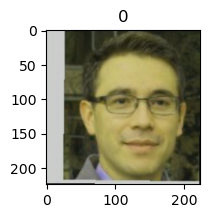

In [47]:
plt.figure(figsize=(2, 2))
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.title(train_dataset[0][1])
plt.show()

## 2. ImageFolder 사용
- 간단하게 사용가능하다.

In [48]:
transforms = T.Compose([
    T.CenterCrop(128),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor()
])

train_dataset = ImageFolder('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/train', transform=transforms)
valid_dataset = ImageFolder('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/val', transform=transforms)

In [15]:
print(len(train_dataset))
print(len(valid_dataset))

104
40


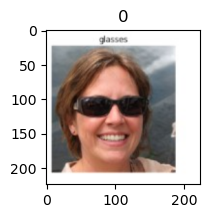

In [16]:
plt.figure(figsize=(2, 2))
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.title(train_dataset[0][1])
plt.show()

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False)

# AlexNet 모델

In [23]:
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
# 파라미터를 고정한다.
for param in model.parameters():
    param.requires_grad = False

In [25]:
# class 개수를 원하는 값으로 변경
model.classifier[6] = torch.nn.Linear(4096, 2)

model.classifier[5].requires_grad = True
model.classifier[6].requires_grad = True

In [26]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train, evalutation

In [30]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_accuracy = 0
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_accuracy_list = []
    train_loss_list = []
    valid_accuracy_list = []
    valid_loss_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)

    return model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list

In [32]:
model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 25)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.235870148986578, Train Accuracy: 0.9134615384615384, Valid Loss: 0.36601756811141967, Valid Accuracy: 0.875


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.2200285316659854, Train Accuracy: 0.9038461538461539, Valid Loss: 0.43171588480472567, Valid Accuracy: 0.75


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.20233886860884154, Train Accuracy: 0.9326923076923077, Valid Loss: 0.3668843150138855, Valid Accuracy: 0.875


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.17518827304817164, Train Accuracy: 0.9326923076923077, Valid Loss: 0.36552954018115996, Valid Accuracy: 0.875


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.13822006434202194, Train Accuracy: 0.9711538461538461, Valid Loss: 0.3889897525310516, Valid Accuracy: 0.825


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.16687009368951505, Train Accuracy: 0.9423076923076923, Valid Loss: 0.3715428948402405, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.16224990154688174, Train Accuracy: 0.9326923076923077, Valid Loss: 0.3767402470111847, Valid Accuracy: 0.825


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.14325575473216864, Train Accuracy: 0.9519230769230769, Valid Loss: 0.3955121964216232, Valid Accuracy: 0.8


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1521870092703746, Train Accuracy: 0.9326923076923077, Valid Loss: 0.34161944389343263, Valid Accuracy: 0.9


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.12875496359685293, Train Accuracy: 0.9519230769230769, Valid Loss: 0.3391881942749023, Valid Accuracy: 0.875


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.17957063391804695, Train Accuracy: 0.9326923076923077, Valid Loss: 0.36690340340137484, Valid Accuracy: 0.825


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1740565994897714, Train Accuracy: 0.9326923076923077, Valid Loss: 0.38852509260177615, Valid Accuracy: 0.825


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.12801683464875588, Train Accuracy: 0.9326923076923077, Valid Loss: 0.3723863884806633, Valid Accuracy: 0.825


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.15575873522231212, Train Accuracy: 0.9326923076923077, Valid Loss: 0.37642499804496765, Valid Accuracy: 0.9


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.13612167107371184, Train Accuracy: 0.9519230769230769, Valid Loss: 0.3945040762424469, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.10657004489061925, Train Accuracy: 0.9807692307692307, Valid Loss: 0.3210556745529175, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.139520813496067, Train Accuracy: 0.9423076923076923, Valid Loss: 0.32292605340480807, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.09918834971120724, Train Accuracy: 0.9519230769230769, Valid Loss: 0.32635834217071535, Valid Accuracy: 0.875


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.14914779006861723, Train Accuracy: 0.9230769230769231, Valid Loss: 0.3512193888425827, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.09988593582350475, Train Accuracy: 0.9615384615384616, Valid Loss: 0.3328323498368263, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.10583698785362336, Train Accuracy: 0.9519230769230769, Valid Loss: 0.33956913501024244, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1572705045915567, Train Accuracy: 0.9326923076923077, Valid Loss: 0.370230907201767, Valid Accuracy: 0.85


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.11673843946594459, Train Accuracy: 0.9519230769230769, Valid Loss: 0.37154304832220075, Valid Accuracy: 0.825


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1052555636717723, Train Accuracy: 0.9615384615384616, Valid Loss: 0.338937883079052, Valid Accuracy: 0.875


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.08069855332947694, Train Accuracy: 0.9807692307692307, Valid Loss: 0.3335438832640648, Valid Accuracy: 0.9


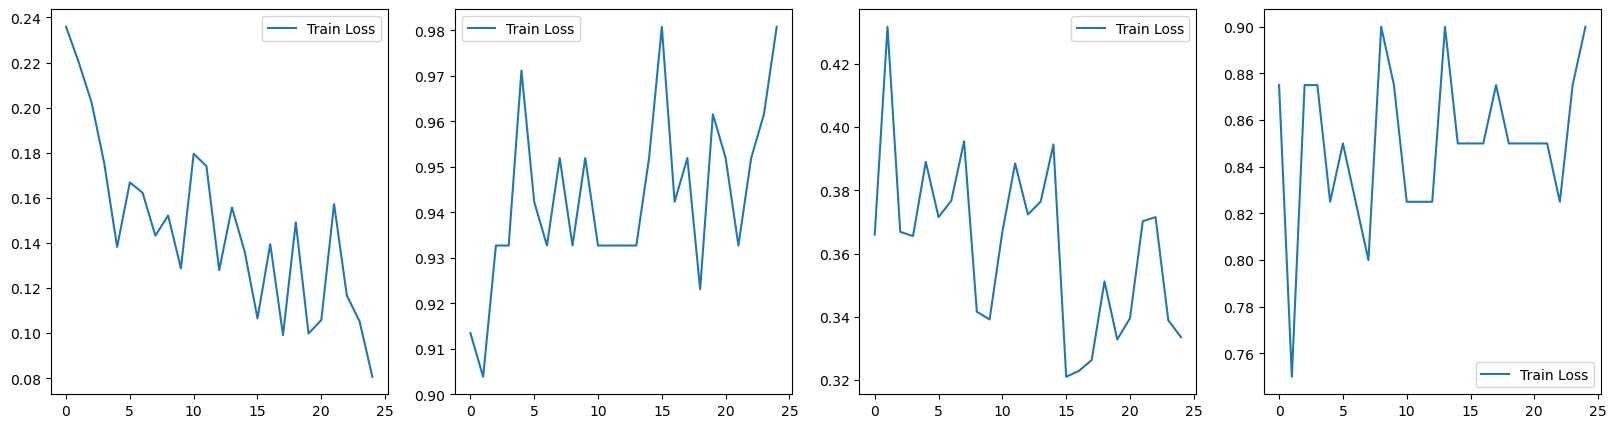

In [50]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_accuracy_list, label='Train Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(valid_loss_list, label='Train Loss')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(valid_accuracy_list, label='Train Loss')
plt.legend()

# test

In [51]:
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/2/data/test', ['glasses', 'noglasses'], transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [52]:
model.eval()

total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)
        total_preds.extend(predicted)

  0%|          | 0/3 [00:00<?, ?it/s]

In [53]:
total_preds

[tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(1, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(1, device='mps:0'),
 tensor(1, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(1, device='mps:0'),
 tensor(1, device='mps:0'),
 tensor(0, device='mps:0'),
 tensor(1, device='mps:0')]

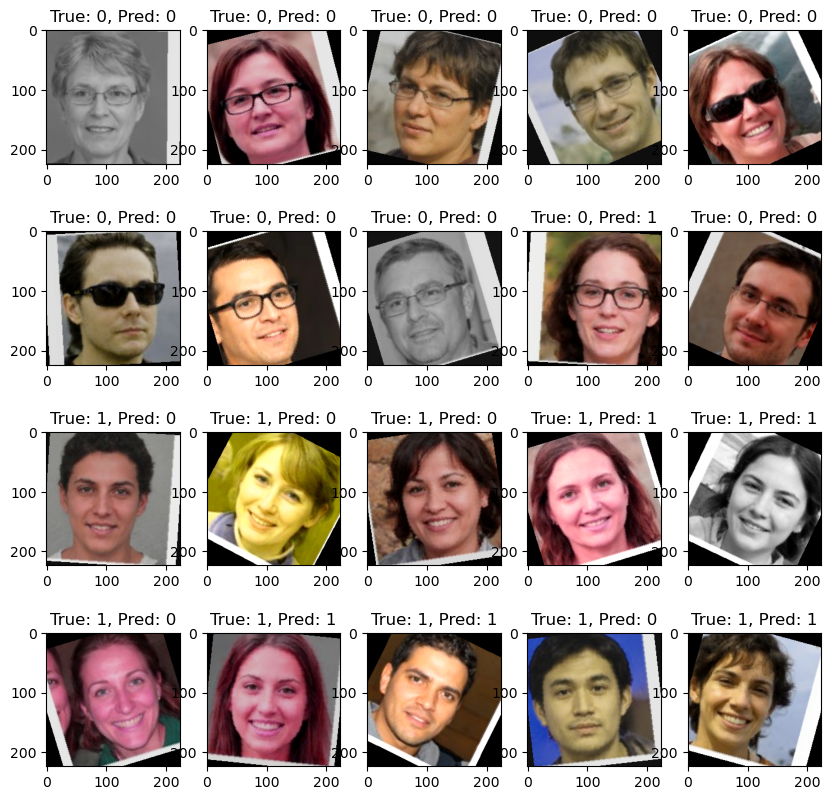

In [56]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {test_dataset[i][1]}, Pred: {total_preds[i].cpu().item()}')